# Lesson 7 - Model evaluation and interpretation

> How to interpret the predictions from Random Forest models and use these insights to prune the feature space.

## Learning objectives

* Understand how to interpret feature importance plots for Random Forest models.
* Know how to drop uninformative features to build simpler models

## References

This lesson is adapted (with permission) from Jeremy Howard's online course [_Introduction to Machine Learning for Coders_](https://course18.fast.ai/ml), in particular:

* [3 — Performance, validation and model interpretation](https://course18.fast.ai/lessonsml1/lesson3.html)

Below are a few relevant articles that may be of general interest:

* [Explaining Feature Importance by example of a Random Forest](https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e)
* [Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)
* [Explainable AI won’t deliver. Here’s why.](https://hackernoon.com/explainable-ai-wont-deliver-here-s-why-6738f54216be)
* [Confidence Intervals](https://dfrieds.com/math/confidence-intervals.html)
* [Reading and Writing Files in Python (Guide)](https://realpython.com/read-write-files-python/)

## Homework

* Work through this notebook

## The data

In this lesson we will analyse the preprocessed table of clean housing data and their addresses that we prepared in lesson 3:

* `housing_processed.csv`

## What is model interpretability?

A nice explanation for what it means to interpret a model's predictions is given in the _Beware Default Random Forest Importances_ article:

> Training a model that accurately predicts outcomes is great, but most of the time you don't just need predictions, you want to be able to interpret your model. For example, if you build a model of house prices, knowing which features are most predictive of price tells us which features people are willing to pay for.

In this lesson we will focus on one specific aspect of interpretability for Random Forests, namely _feature importance_ which is a technique that (with care) can be used to identify the most informative features in a dataset.

## Import libraries

In [1]:
# data wrangling
import pandas as pd
import numpy as np

# data visualisations
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import scipy
from scipy.cluster import hierarchy as hc

## Load the data

In [2]:
housing_data = pd.read_csv('housing_processed.csv'); housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,city,rooms_per_household,bedrooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_INLAND,ocean_proximity_<1H OCEAN,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,ocean_proximity_ISLAND
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,69,6.984127,1.023810,0.146591,2.555556,0,0,1,0,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,620,6.238137,0.971880,0.155797,2.109842,0,0,1,0,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,620,8.288136,1.073446,0.129516,2.802260,0,0,1,0,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,620,5.817352,1.073059,0.184458,2.547945,0,0,1,0,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,620,6.281853,1.081081,0.172096,2.181467,0,0,1,0,0


With the data loaded, we can recreate our train/validation splits as before:

In [3]:
X = housing_data.drop('median_house_value', axis=1)
y = housing_data['median_house_value']

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'{len(X_train)} train rows + {len(X_valid)} valid rows')

15554 train rows + 3889 valid rows


To simplify the evaluation of our models, we'll reuse our scoring function from our previous lesson:

In [5]:
def print_rf_scores(fitted_model):
    """Generates RMSE and R^2 scores from fitted Random Forest model."""

    yhat_train = fitted_model.predict(X_train)
    R2_train = fitted_model.score(X_train, y_train)
    yhat_valid = fitted_model.predict(X_valid)
    R2_valid = fitted_model.score(X_valid, y_valid)

    scores = {
        "RMSE on train:": rmse(y_train, yhat_train),
        "R^2 on train:": R2_train,
        "RMSE on valid:": rmse(y_valid, yhat_valid),
        "R^2 on valid:": R2_valid,
    }
    if hasattr(fitted_model, "oob_score_"):
        scores["OOB R^2:"] = fitted_model.oob_score_

    for score_name, score_value in scores.items():
        print(score_name, round(score_value, 3))

def rmse(y, yhat):
    """A utility function to calculate the Root Mean Square Error (RMSE).
    
    Args:
        y (array): Actual values for target.
        yhat (array): Predicted values for target.
        
    Returns:
        rmse (double): The RMSE.
    """
    return np.sqrt(mean_squared_error(y, yhat))

## Confidence intervals

Recall that to make predictions with our Random Forest models, we take the _average value_ in each leaf node as we pass each row in the validation set through the tree. However, we would also like to estimate our _**confidence**_ in these predictions - how can we achieve this?

One way to do this is to calculate the _**standard deviation of the predictions**_ of the trees. Conceptually, the idea is that if the standard deviation is high, each tree is generating very different predictions and may indicate the model has not learnt the most important features of the data.

To get started, let's use the following baseline model:

In [7]:
model = RandomForestRegressor(n_estimators=40, max_features='sqrt', oob_score=True, random_state=42)  # max_features=sqrt(n_features)
model.fit(X_train, y_train)
print_rf_scores(model)

RMSE on train: 17178.571
R^2 on train: 0.968
RMSE on valid: 44720.654
R^2 on valid: 0.792
OOB R^2: 0.774


As before, we concatenate all the predictions from each tree into a single array:

In [114]:
preds = np.stack([t.predict(X_valid) for t in model.estimators_])
# calculate mean and standard deviation for single observation
print(np.mean(preds[:,0]))
print(np.std(preds[:,0]))

C:\Users\joelt\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\joelt\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  

152764.5
22733.313215411432


In [32]:
print(preds.shape) # 40 trees, 3889 observations
preds


(40, 3889)


array([[139400.,  94600., 202400., ..., 302900., 231400., 193800.],
       [111400., 100300., 125000., ..., 251200., 285600.,  87500.],
       [ 92600., 232800., 120700., ..., 329200., 487800., 187500.],
       ...,
       [179800., 176500.,  93100., ..., 268300., 466900., 450000.],
       [275000., 184400., 158900., ..., 245800., 361500.,  87700.],
       [ 92600., 160300., 105100., ..., 295200., 293000., 340400.]])

Next, let's create a copy of the validation dataset and add the mean predictions and their standard deviation as new columns.

---

#### Exercise #1

* Combine `X_valid` and `y_valid` into a single array called `valid_copy`. You may find the `concat` method from pandas useful here.
* Create two new columns `preds_mean` and `preds_std` that are the mean and standard deviation of the predictions for each tree in `preds`

---

In [31]:
valid_copy = pd.concat([X_valid, y_valid], axis=1)
valid_copy.shape

(3889, 19)

In [39]:
"""
preds_mean = []
preds_std = []

trees = range(preds.shape[0])
predictions = range(preds.shape[1])

for prediction in predictions:

    prediciton_list = []

    for tree in trees:
        prediciton_list.append(preds[tree,prediction])

    preds_mean.append(np.array(prediciton_list).mean())
    preds_std.append(np.array(prediciton_list).std())

print(len(preds_mean))
print(len(preds_std))
"""


3889
3889


In [47]:
preds_mean = []
preds_std = []

for i in range(preds.shape[1]):
    preds_mean.append(np.mean(preds[:,i]))
    preds_std.append(np.std(preds[:,i]))

print(len(preds_mean))
print(len(preds_std))


3889
3889


In [49]:
valid_copy["preds_mean"] = preds_mean
valid_copy["preds_std"] = preds_std
print(valid_copy.shape)
valid_copy.head()

(3889, 21)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,city,rooms_per_household,...,bedrooms_per_room,population_per_household,ocean_proximity_INLAND,ocean_proximity_<1H OCEAN,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,ocean_proximity_ISLAND,median_house_value,preds_mean,preds_std
15330,-121.36,37.96,32.0,614.0,95.0,227.0,107.0,3.9922,858,5.738318,...,0.154723,2.121495,1,0,0,0,0,247400.0,147727.5,57742.025369
17818,-121.98,38.25,4.0,2487.0,440.0,1545.0,452.0,4.9103,862,5.502212,...,0.176920,3.418142,1,0,0,0,0,140400.0,173410.0,54661.662982
7221,-118.21,33.89,45.0,1211.0,234.0,1128.0,261.0,3.4792,188,4.639847,...,0.193229,4.321839,0,1,0,0,0,110700.0,132485.0,24839.711653
13936,-117.09,32.79,20.0,2183.0,534.0,999.0,496.0,2.8631,770,4.401210,...,0.244617,2.014113,0,0,0,1,0,169700.0,179522.5,45570.854104
10428,-117.88,33.84,26.0,1499.0,290.0,755.0,277.0,3.5893,18,5.411552,...,0.193462,2.725632,0,1,0,0,0,238500.0,219182.5,48405.866832


We can use these new columns to drill-down into the predictions of each individual, categorical feature. Let's examine `ocean_proximity_INLAND` which denotes whether a housing district is inland or not:

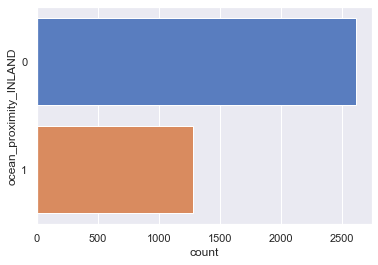

In [50]:
sns.countplot(y='ocean_proximity_INLAND', data=valid_copy);

We can calculate the predictions and standard deviation per category by applying a _**group by**_ operation in pandas, followed by taking the mean.

In [51]:
cols = ['ocean_proximity_INLAND', 'median_house_value', 'preds_mean', 'preds_std']
preds_quality = valid_copy[cols].groupby('ocean_proximity_INLAND', as_index=False).mean() # Mean median_house_value (and means of preds_mean, preds_std) by ocean proximity group
preds_quality

,ocean_proximity_INLAND,median_house_value,preds_mean,preds_std
0,0,227863.194178,227773.595347,54209.909429
1,1,123654.224570,124872.452563,38698.515457


From the table, we can see that the predictions and ground truth are close to each other on average, while the standard deviation varies somewhat for each category. We can visualise this table in terms of bar plots as follows:

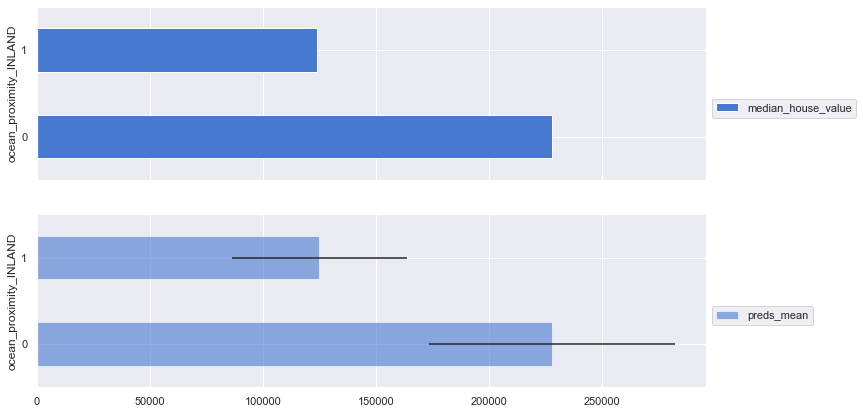

In [52]:
# prepare figure 
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(12,7), sharex=True)

# plot ground truth
preds_quality.plot('ocean_proximity_INLAND', 'median_house_value', 'barh', ax=ax0)
# put legend outside plot
ax0.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))

# plot preds
preds_quality.plot('ocean_proximity_INLAND', 'preds_mean', 'barh', xerr='preds_std', alpha=0.6, ax=ax1)
# put legend outside plot
ax1.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))

plt.show()

The error bars in the plot indicate how confident the model is at predicting each category.  Alternatively, we can compare the _distribution_ of values to inspect how close the predictions match the ground truth. For example, for housing districts where `ocean_proximity_INLAND` is 0 we have:

C:\Users\joelt\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


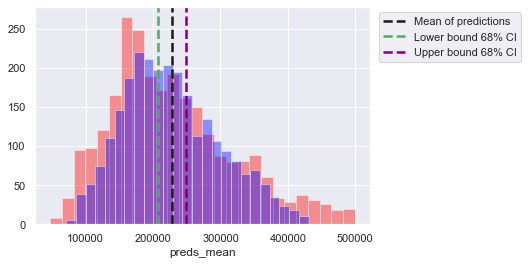

In [53]:
sample = valid_copy.copy().loc[valid_copy["ocean_proximity_INLAND"] == 0]
sample_mean = sample['preds_mean'].mean()
sample_std = sample['preds_std'].std()
lower_bound = sample_mean - sample_std
upper_bound = sample_mean + sample_std

sns.distplot(
    sample["median_house_value"], kde=False, color="red",  # actual house values (ground truth) in red and purple 
)
sns.distplot(sample["preds_mean"], kde=False, color="blue",) # predicted house value in blue and purple
plt.axvline(
    x=sample_mean,
    linestyle="--",
    linewidth=2.5,
    label="Mean of predictions",
    c="k",
)
plt.axvline(
    x=lower_bound,
    linestyle="--",
    linewidth=2.5,
    label="Lower bound 68% CI",
    c="g",
)
plt.axvline(
    x=upper_bound,
    linestyle="--",
    linewidth=2.5,
    label="Upper bound 68% CI",
    c="purple",
)
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left");

In general, we expect our models to perform best on categories that are most frequent in the data. One way to validate this hypothesis is by calculating the ratio of the standard deviation of the predictions to the predictions themselves:

In [54]:
preds_quality = valid_copy[cols].groupby("ocean_proximity_INLAND", as_index=True).mean()
(preds_quality["preds_std"] / preds_quality["preds_mean"]).sort_values(ascending=False)

ocean_proximity_INLAND
1    0.309904
0    0.237999
dtype: float64

What the above tells us is that our predictions are less confident (i.e. higher variance) for housing districts that are inland (i.e. where `ocean_proximity_INLAND` is 1) - indeed looking at our bar plot we see these categories are under-represented in the data!

In general, confidence intervals serve the following purpose: We can identify which rows (instances, here: housing districts) in the data the model is not confident about. This is particularly important when deploying models to production, where e.g. we need to decide how to evaluate the model's predictions for a _single_ housing district.

## Feature importance

One drawback with the confidence interval analysis is that we need to drill-down into each feature to see where the model is making mistakes. In practice, we can get a global view by ranking each feature in terms of its importance to the model's predictions. In scikit-learn, the Random Forest model has an attribute called `feature_importances_` that we can use to rank each feature:

In [55]:
def rf_feature_importance(fitted_model, df):
    return pd.DataFrame(
        {"Column": df.columns, "Importance": fitted_model.feature_importances_}
    ).sort_values("Importance", ascending=False)

Let's use this function to calculate the feature importance for our fitted model:

In [56]:
feature_importance = rf_feature_importance(model, X)

# peek at top 10 features
feature_importance[:10]

,Column,Importance
7,median_income,0.265594
13,ocean_proximity_INLAND,0.125925
12,population_per_household,0.090746
1,latitude,0.084421
0,longitude,0.083812
11,bedrooms_per_room,0.074575
9,rooms_per_household,0.053011
2,housing_median_age,0.038275
8,city,0.031156
14,ocean_proximity_<1H OCEAN,0.027536


From the table we see that `median_income`, `ocean_proximity_INLAND`, and `population_per_household` are the most important features - this is not entirely surprising since income and house location seem to be good indicators of house value. We can also plot the feature importance to gain a visual understanding:

In [57]:
def plot_feature_importance(feature_importance):
    return sns.barplot(y="Column", x="Importance", data=feature_importance, color='b')

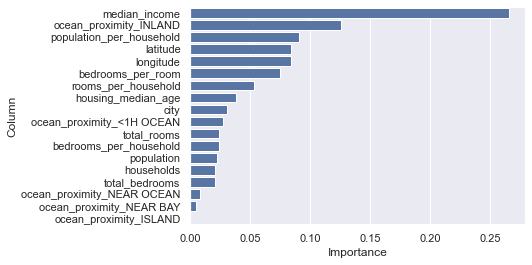

In [58]:
plot_feature_importance(feature_importance);

In nearly every real-world dataset, this is what the feature importance looks like: a handful of columns are very important, while most are not. The powerful aspect of this approach is that is _focuses our attention_ on which features we should investigate further and which ones we can safely ignore.

## Drop uninformative features

From the feature importance plot above, we can see there are only a handful of informative features - let's use this insight to make a simpler model by dropping uninformative columns from our data:

In [60]:
feature_importance_threshold = 0.03
cols_to_keep = feature_importance[
    feature_importance['Importance'] > feature_importance_threshold
]['Column']

len(cols_to_keep)

9

In [61]:
# create a copy of the data with the selected columns and create new train / test set
X_keep = X.copy()[cols_to_keep]
X_train, X_valid = train_test_split(X_keep, test_size=0.2, random_state=42)

In [62]:
X_keep.head()

,median_income,ocean_proximity_INLAND,population_per_household,latitude,longitude,bedrooms_per_room,rooms_per_household,housing_median_age,city
0,8.3252,0,2.555556,37.88,-122.23,0.146591,6.984127,41.0,69
1,8.3014,0,2.109842,37.86,-122.22,0.155797,6.238137,21.0,620
2,7.2574,0,2.802260,37.85,-122.24,0.129516,8.288136,52.0,620
3,5.6431,0,2.547945,37.85,-122.25,0.184458,5.817352,52.0,620
4,3.8462,0,2.181467,37.85,-122.25,0.172096,6.281853,52.0,620


As a sanity check, let's ensure the model's prediction does not deteriorate significantly with the smaller dataset:

In [63]:
model = RandomForestRegressor(
    n_estimators=40, min_samples_leaf=1, n_jobs=-1, oob_score=True, random_state=42
)
model.fit(X_train, y_train)
print_rf_scores(model) # Similar OOB R^2

RMSE on train: 16951.774
R^2 on train: 0.969
RMSE on valid: 44798.26
R^2 on valid: 0.791
OOB R^2: 0.781


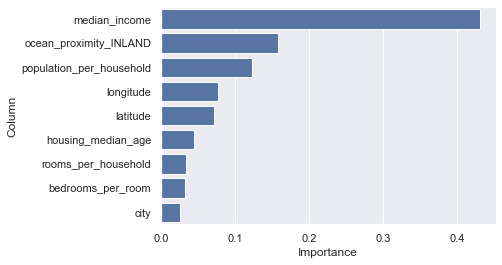

In [64]:
feature_importance = rf_feature_importance(model, X_keep)
plot_feature_importance(feature_importance);

We've now got a model that isn't really more predictive than our baseline, but it's much simpler - it has just 9 features instead of 19 and we now know that `median_income` and `ocean_proximity_INLAND` are particularly important features to focus on.

---

#### Exercise #2

Go through the features to gain insights into things like the following: What is the relationship between each feature and the target `median_house_value`?

---

In [96]:
X_keep["predicted_medain_house_value"] = model.predict(X_keep)

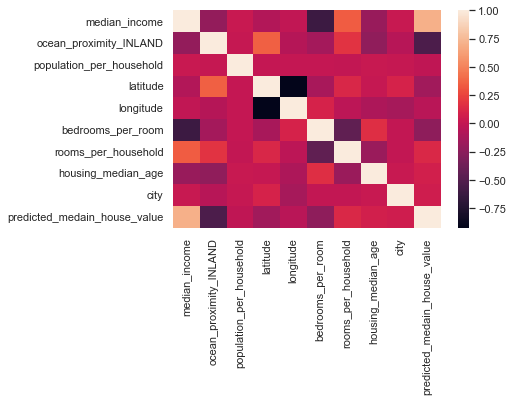

In [97]:
corr_mat = X_keep.corr()
fig = sns.heatmap(corr_mat)

In [99]:
corr_mat["predicted_medain_house_value"].sort_values(ascending= False)

predicted_medain_house_value    1.000000
median_income                   0.703847
rooms_per_household             0.123325
housing_median_age              0.068889
city                            0.054542
population_per_household       -0.017461
longitude                      -0.047086
latitude                       -0.156546
bedrooms_per_room              -0.236988
ocean_proximity_INLAND         -0.539289
Name: predicted_medain_house_value, dtype: float64

## Removing redundant features

To identify features that are potentially redundant, let's create a function that trains a Random Forest on subsets of the data where one of the columns is removed and see in which cases the OOB score does not get worse:

In [100]:
def get_oob(df):
    model = RandomForestRegressor(
        n_estimators=40, max_features='sqrt', n_jobs=-1, oob_score=True, random_state=42
    )
    X, _ = train_test_split(df, test_size=0.2, random_state=42)
    model.fit(X, y_train)
    return model.oob_score_

In [101]:
# calculate reference value
get_oob(X_keep)

0.9730901620190029

In [103]:
for column in (
    "longitude",
    "population_per_household",
    "housing_median_age",
    "bedrooms_per_room",
    "latitude",
    "city",
    "rooms_per_household",
    "median_income",
):
    print(column, get_oob(X_keep.drop(column, axis=1))) # drop each of these features in turn and check the out-of-bage 

longitude 0.9744119567539086
population_per_household 0.9734647704042159
housing_median_age 0.9747204723615417
bedrooms_per_room 0.974897714603222
latitude 0.9745304897363813
city 0.9760338653191573
rooms_per_household 0.9747444985469081
median_income 0.9715882858165852


If we drop `rooms_per_household` or `bedrooms_per_room`, the OOB score will increase a bit. So let's see what happens to our OOB score when we drop these candidate columns:

In [104]:
cols_to_drop = [
    'bedrooms_per_room',
    "rooms_per_household",
]
get_oob(X_keep.drop(cols_to_drop, axis=1))

0.9687892807648796

The OOB score increases fractionally which is good since we're looking for a simpler model - let's drop these columns and run the full model again:

In [105]:
X_keep.drop(cols_to_drop, axis=1, inplace=True)
X_train, X_valid = train_test_split(X_keep, test_size=0.2, random_state=42)

In [106]:
model = RandomForestRegressor(n_estimators=40, max_features='sqrt', n_jobs=-1, oob_score=True, random_state=42)
model.fit(X_train, y_train)
print_rf_scores(model)

RMSE on train: 6766.517
R^2 on train: 0.995
RMSE on valid: 44155.531
R^2 on valid: 0.797
OOB R^2: 0.969


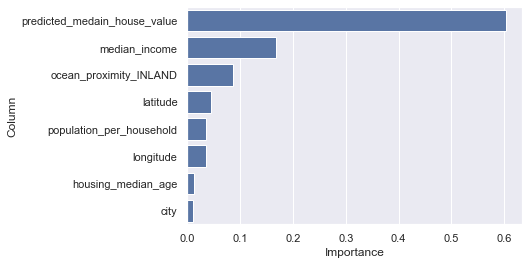

In [107]:
feature_importance = rf_feature_importance(model, X_keep)
plot_feature_importance(feature_importance);

## Our final model

Now that we have simplified our model, let's create a huge Random Forest to see if we can squeeze a bit more performance:

In [108]:
model = RandomForestRegressor(
    n_estimators=1000, max_features='sqrt', n_jobs=-1, oob_score=True, random_state=42
)
model.fit(X_train, y_train)
print_rf_scores(model)

RMSE on train: 5795.587
R^2 on train: 0.996
RMSE on valid: 44081.359
R^2 on valid: 0.798
OOB R^2: 0.974


Our final model achieves around 5% better performance compared to our naive model with 10 trees from lesson 4, but it is _much simpler_ - we've reduced the features from 19 down to 7! Moreover we've identified which features are most important, let's plot them out for the final visual comparison:

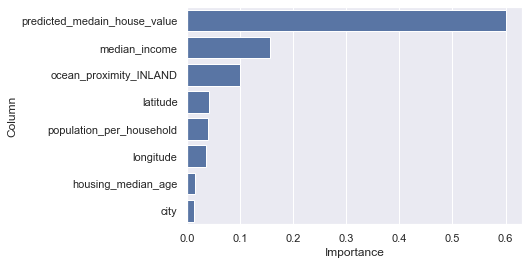

In [109]:
feature_importance = rf_feature_importance(model, X_keep)
plot_feature_importance(feature_importance);

### Save model to disk

Finally let's save this model to disk for later use or if we want to deploy it to production:

In [110]:
import pickle

with open('housing_model.pkl', mode='wb') as file:
    pickle.dump(model, file)

In [111]:
# sanity check
with open('housing_model.pkl', mode='rb') as file:
    model = pickle.load(file)

In [112]:
print_rf_scores(model)

RMSE on train: 5795.587
R^2 on train: 0.996
RMSE on valid: 44081.359
R^2 on valid: 0.798
OOB R^2: 0.974


> Note: We often use the `with` statement to read or write data in Python as this automatically takes care of closing the file once we have finished with it. The `mode` argument controls how we want to open the file, where `'rb'` (read) and `'wb'` (write) correspond to opening in binary mode.